<a href="https://colab.research.google.com/github/kimsooyoung/practical_jetson_examples/blob/main/Digits%20Recognition%20with%20MNIST/%5BPractical%20Jetson%20%231-4%5D%20Digits_Recognition_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practical Exercise with MNIST Example #1-4 - "Predict with CNN Model"**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Colab only
from google.colab.patches import cv2_imshow

## **GPU usability check**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## **Same Model as Before**

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()


        #### Layer1 ####
        # Image Input shape = (Data Length, Width, Height, Channel)
        # Input shape = (N, 28, 28, 1)
        # Conv = (N, 28, 28, 32)
        # Pool = (N, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        #### Layer2 ####
        # Input shape = (N, 14, 14, 32)
        # Conv = (N, 14, 14, 64)
        # Pool = (N, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        #### Layer3 ####
        # Fully connected layer
        # Input shape = (N, 7, 7, 64)
        # Output = (N, 10)
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # Initialize weights with Xavier initialization to the fully connected layer only
        torch.nn.init.xavier_uniform_(self.fc.weight)

    # forward pass
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # flatten for fully connected layer
        out = self.fc(out)
        return out

## **Load pretained parameters**

In [ ]:
def load_model(model_path):
    model = CNN()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Set the model to Inference Mode
    model.eval()

    return model

**[!important] You must have to import a trained `.pth` file in this workspace!**

In [ ]:
import os.path
model_path = "./CNN_trained_model.pth"

if os.path.isfile(model_path):
  print("Model File Found and Loaded Keep Going :)")
  model = load_model(model_path)
else:
  print("[ERROR] No Model File Found :(")

Model File Found and Loaded Keep Going :)


## **Handwritten Digit Recognition**

In [ ]:
def preprocess_image_opencv(image_path):
    ''' The is a function that for one image preprocesses it.'''

    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Color to grayscale
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)         # Gaussian Kernel, kernel size (5, 5)

    # Adaptive threshold processing better with variable lighting:
    # ref : https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    # cv2.ADAPTIVE_THRESH_GAUSSIAN_C: Adaptive threshold processing method using Gaussian weighted averages
    # cv2.THRESH_BINARY_INV: Binary conversion and invert black & white. (Original datasets have white letters, so need to be inverted)
    final_img = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, blockSize = 321, C = 28)

    # visualize image
    cv2_imshow(final_img)

    # image resize for model input
    image = cv2.resize(final_img, (28, 28))

    # image to PyTorch Tensor
    image_tensor = transforms.ToTensor()(image).unsqueeze(0)

    return image_tensor


def predict(model, image_tensor):
    '''Uses the CNN model to predict the number of images'''

    with torch.no_grad():
        model.to(device)
        model.eval()
        output = model(image_tensor)

        _, predicted_class = torch.max(output, 1)

        # .item() : vector to scalar
        return predicted_class.item()

## **Change image path/name and run prediction!**

**[!important] You must specify image file name and path in this workspace!**

In [ ]:
import os.path

image_path = './demo_3.png'

if os.path.isfile(image_path):
  print("Image File Found Keep Going :)")
else:
  print("[ERROR] No Image File :(")

Image File Found Keep Going :)


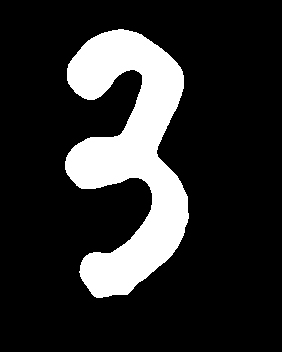

./demo_3.png Predicted class: 3


In [ ]:
''' Pre-processing and prediction of images '''

image_tensor = preprocess_image_opencv(image_path)
predicted_class = predict(model, image_tensor.to(device))
print(f"{image_path} Predicted class: {predicted_class}")